# Zillow Project
---
## __Robust Analytics™__

__Anthony Straine__<br>
Junior Data Scientist

__Christopher Ortiz__<br>
Junior Data Scientist


## Summary
Working together we discovered for our MVP that the features that appear to drive home value as measure by taxvaluedollarcnt are bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet. We discovered this by going through an iterative, manual process of feature selection using a Pearson's R correlation test to select the top two features of bathroomcnt and calculatedfinishedsquarefeet and using industry knowledge to also include calculatedfinishedsquarefeet and homes having more than 2 bathrooms. After testing a few models, the model that performed the best was our model1 data (bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt) and using a Polynomial-features algorithm. The features in this model explain 47% of the variance.

For our next iteration we will look at additional features while controlling for outliers.


<div class='alert alert-block alert-info'>Tax Rate Distributions are located in the <strong>Appendix</strong></div>

## Content
- [Acquisition](#acquisition)
- [Preparation](#preparation)
- [Exploration](#exploration)
- [Modeling](#modeling)
- [Summary](#summary)
- [Appendix](#appendix)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats

from sklearn.feature_selection import RFE
from acquire import load_zillow_data
from prepare import prepare_zillow, load_zillow_tax_data
from wrangle import wrangle_data, select_kbest, select_rfe, features_for_modeling

import warnings
warnings.filterwarnings("ignore")

# Acquisition
---

In [2]:
df_zillow = load_zillow_data()

In [3]:
df_zillow.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,11393337,2463969,NaN,NaN,NaN,3.0,3.0,NaN,4.0,3.0,...,43439.0,2016.0,22755.0,756.94,Y,14.0,6.037235e+13,117,0.086137,2017-06-08
1,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
2,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30
3,14269464,1923117,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,...,880456.0,2016.0,445569.0,9819.72,NaN,NaN,6.059064e+13,2028,0.021085,2017-06-01
4,11389003,2121349,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,614000.0,2016.0,449000.0,7673.19,NaN,NaN,6.037703e+13,3273,-0.325393,2017-06-01


#  Preparation
---

In [4]:
df = prepare_zillow()

In [5]:
df.shape

(14562, 11)

In [6]:
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,propertylandusetypeid,roomcnt,yearbuilt,taxvaluedollarcnt,more_than_two_bath
1,11289917,2.0,3.0,1458.0,6037.0,8284.0,261.0,0.0,1970.0,136104.0,0
2,11705026,1.0,2.0,1421.0,6037.0,6707.0,261.0,0.0,1911.0,35606.0,0
3,14269464,3.0,4.0,2541.0,6059.0,4975.0,261.0,0.0,2003.0,880456.0,1
4,11389003,2.0,3.0,1650.0,6037.0,7300.0,261.0,0.0,1949.0,614000.0,0
5,11967869,1.0,2.0,693.0,6037.0,2908.0,261.0,0.0,1921.0,274237.0,0


In [7]:
df.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fips', 'lotsizesquarefeet', 'propertylandusetypeid', 'roomcnt',
       'yearbuilt', 'taxvaluedollarcnt', 'more_than_two_bath'],
      dtype='object')

#  Exploration
---
- Discover insights in data with visuals.
- [Outlier Detection](#Outlier-Detection)
- [Hypothesis Testing](#Hypothesis-Testing)

> Before or after hypothesis tests?
> - Recursive Feature Elimination
> - SelectKBest

## Outlier Detection
Outliers can completely skew results of staticial testing. Detecting and handling outliers is important to the modeling process. We will do this below.

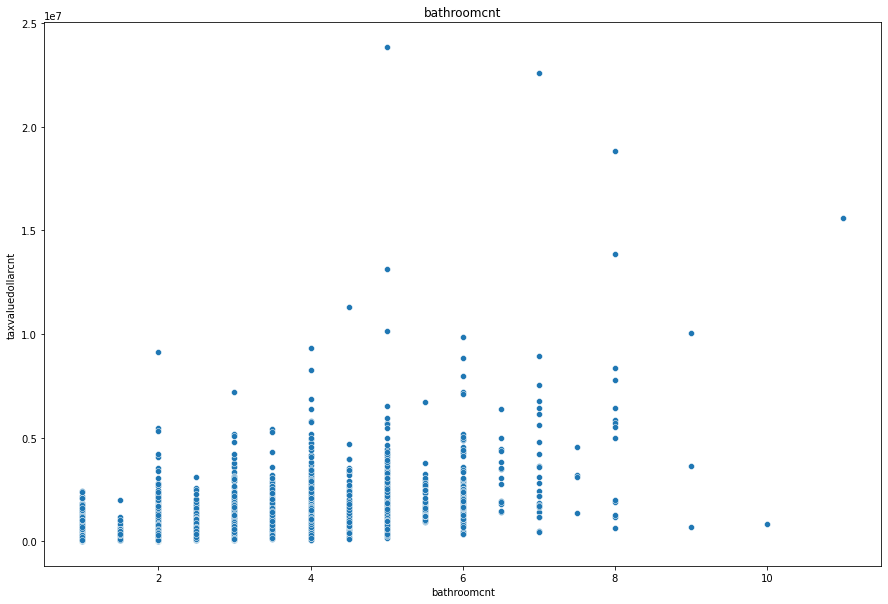

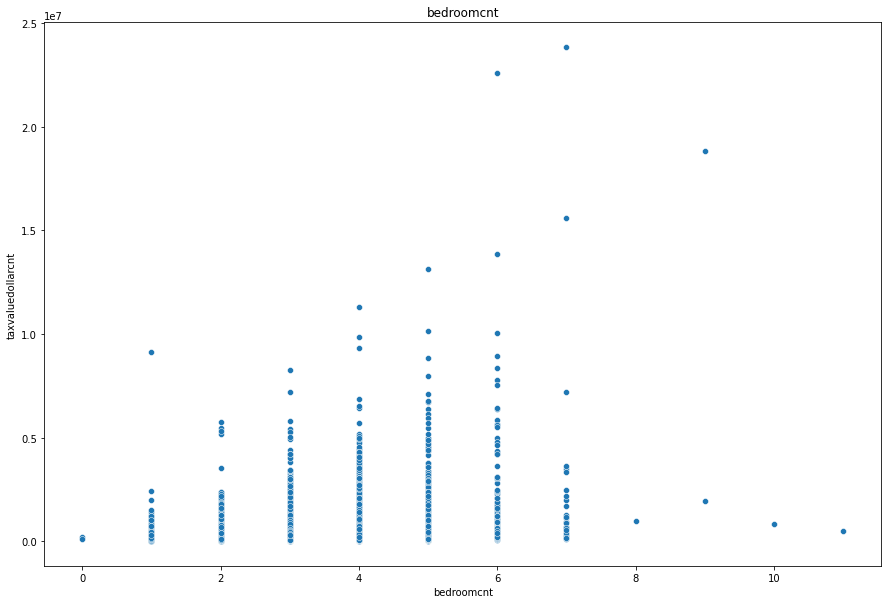

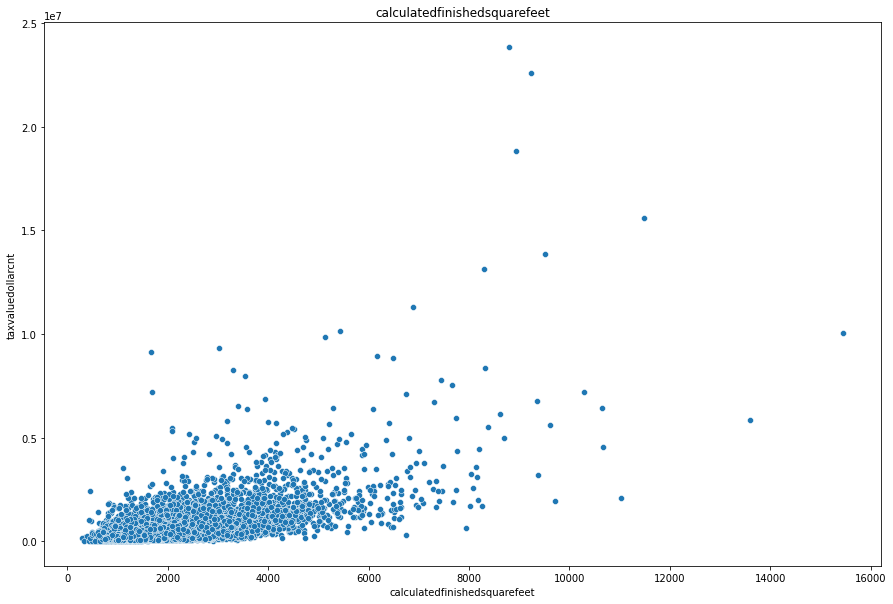

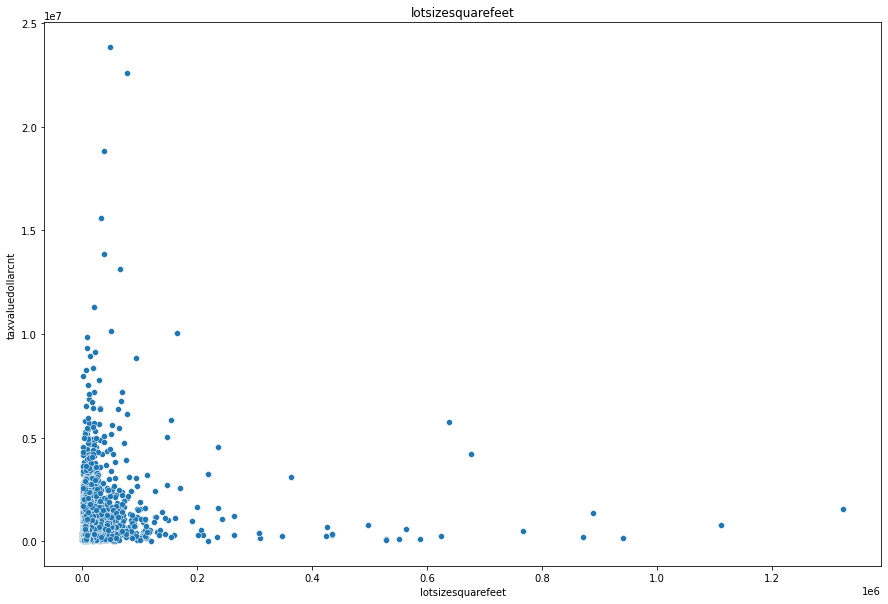

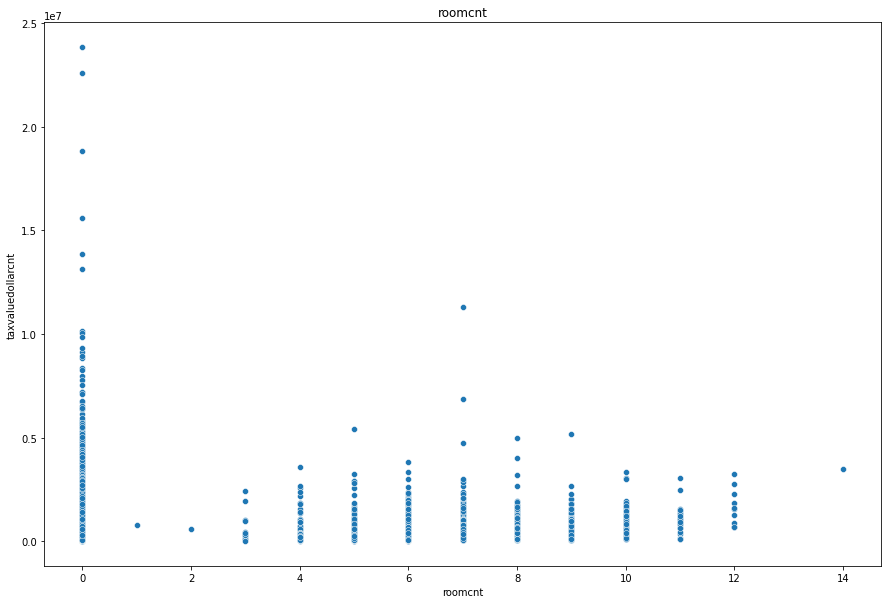

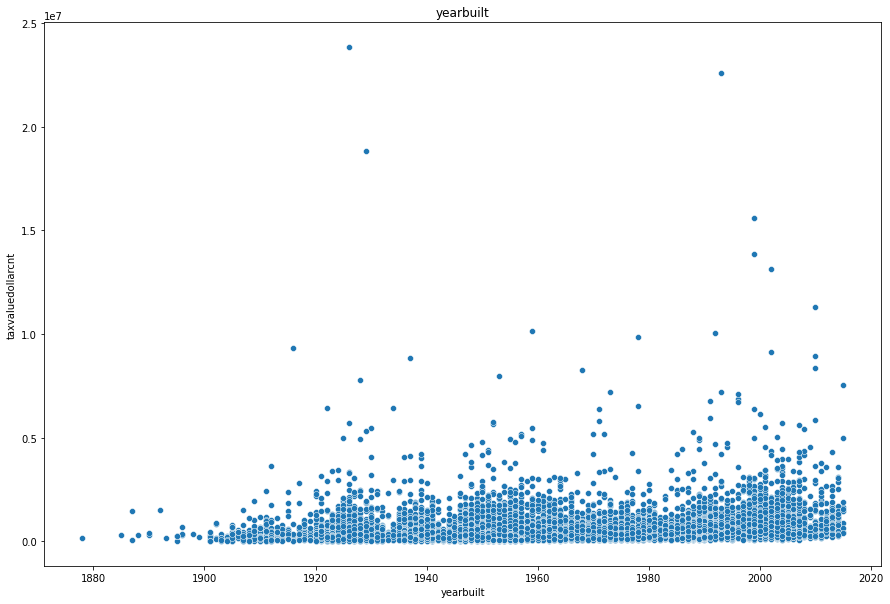

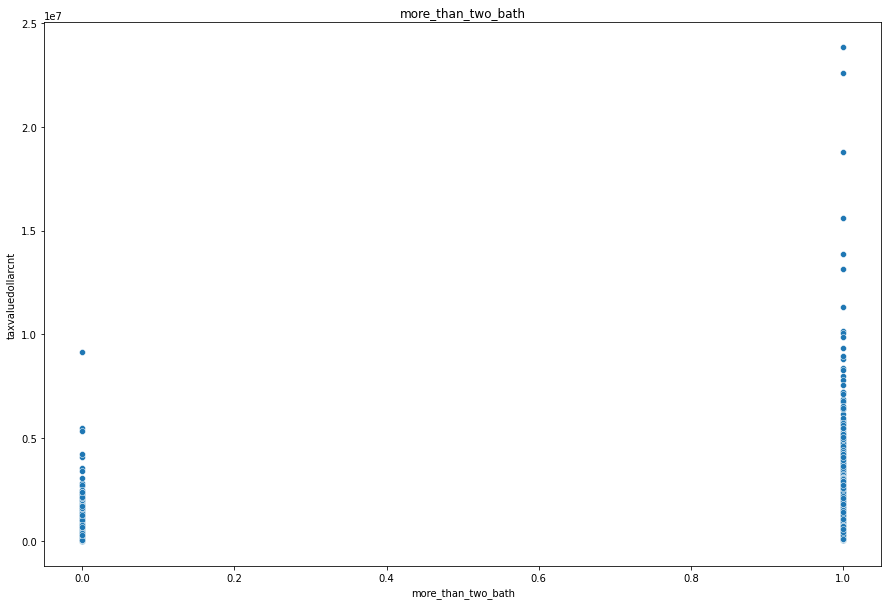

In [8]:
# Visualize a scatter plot of all the columns that we can use for analysis from the df
# create a list of columns we wish to visualize.
columns = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
           'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'more_than_two_bath']

# loop through the columns and create a scatter plot for each feature and target pair
for col in columns:
    plt.figure(figsize=(15,10))
    sns.scatterplot(data=df, x=col, y='taxvaluedollarcnt')
    plt.title(col)

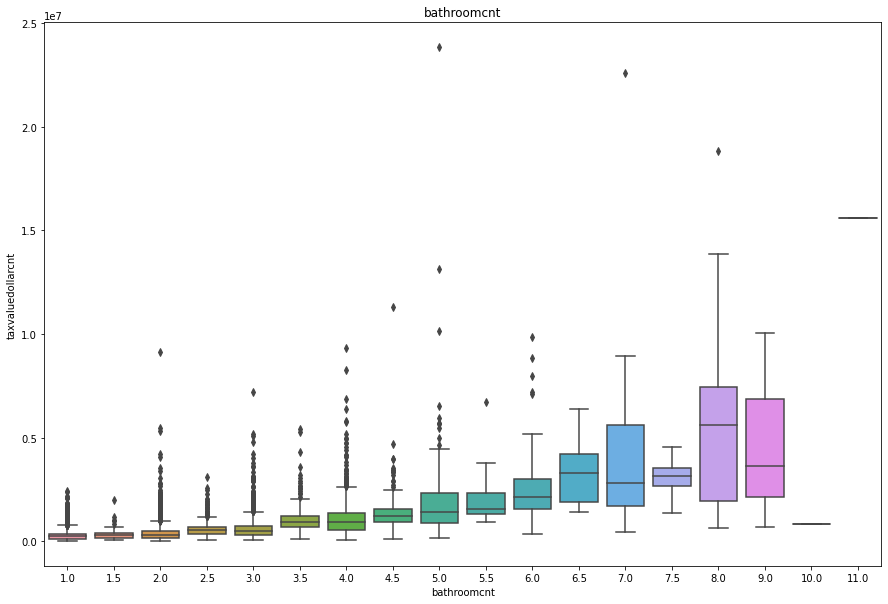

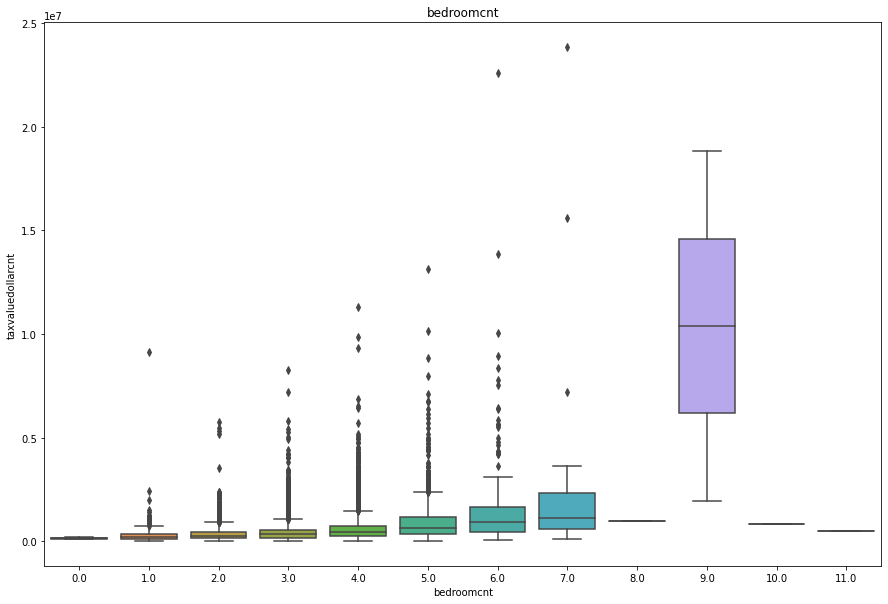

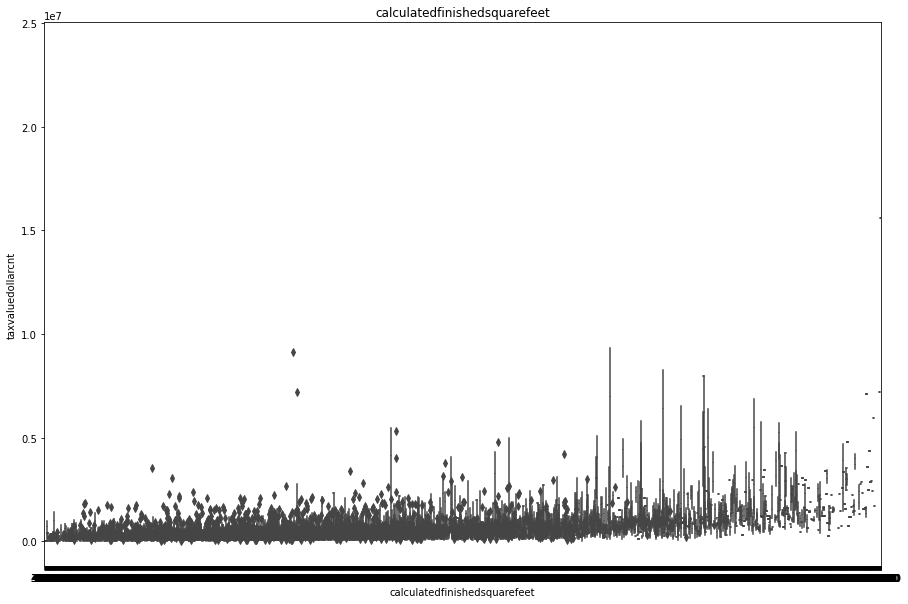

In [ ]:
# Repeat the process for scatter plots, but use boxplots
# create a list of columns we wish to visualize.
columns = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
           'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'more_than_two_bath']

# loop through the columns and create a scatter plot for each feature and target pair
for col in columns:
    plt.figure(figsize=(15,10))
    sns.boxplot(data=df, x=col, y='taxvaluedollarcnt')
    plt.title(col)

In [ ]:
# Createa data frame of the df.desciption() for features that have outliers
des = df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
          'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'more_than_two_bath']].describe()
des

In [ ]:
# Get a list of the columns from the description
columns = list(des.columns)

# Create an empty list to store the results of our testing called outliers
outliers = []
# Use a for loop to loop through the Des data frame and store the results in the empty list
for col in columns:
    IQR = (des[col].iloc[6] - des[col].iloc[4])
    Q3 = des[col].iloc[6]
    Q1 = des[col].iloc[4]
    little_outliers = Q1 - (1.5 * IQR)
    big_outliers = Q3 + (1.5 * IQR)
    outliers.append([IQR, Q3, Q1, little_outliers, big_outliers])

# Convert new list to a np.array and then to a data frame
outliers = np.array(outliers)
df_outliers = pd.DataFrame(data=outliers, index = columns, columns = ['IQR', 'Q3', 'Q1', 'little_outliers', 'big_outliers'])

# transpose the data frame and split it between big_outliers and little_outliers
big_outliers = df_outliers[['big_outliers']].transpose()
big_outliers

In [ ]:
little_outliers = df_outliers[['little_outliers']].transpose()
little_outliers

In [ ]:
# Create outlier columns for each feature tested
df['bathroomcnt_outlier'] = (df['bathroomcnt'] > 4.5) | (df['bathroomcnt'] < .05)
df['bedroomcnt_outlier'] = (df['bedroomcnt'] > 5.5) | (df['bedroomcnt'] < 1.5)
df['calculatedfinishedsquarefeet_outlier'] = (df['calculatedfinishedsquarefeet'] > 3633.0)
df['roomcnt_outlier'] = (df['roomcnt'] > 12.5)
df['yearbuilt_outlier'] = (df['yearbuilt'] > 2016.5) | (df['yearbuilt'] < 1908.5)

# Print the % of outliers
print(f"bathroomcnt_outlier - {df['bathroomcnt_outlier'].sum()/df.shape[0]:.2%}")
print(f"bedroomcnt_outlier - {df['bedroomcnt_outlier'].sum()/df.shape[0]:.2%}")
print(f"calculatedfinishedsquarefeet_outlier - {df['calculatedfinishedsquarefeet_outlier'].sum()/df.shape[0]:.2%}")
print(f"roomcnt_outlier - {df['roomcnt_outlier'].sum()/df.shape[0]:.2%}")
print(f"yearbuilt_outlier - {df['yearbuilt_outlier'].sum()/df.shape[0]:.2%}")

In [ ]:
# Choose which outliers (if any) to drop

# df.drop(df.loc[df['bathroomcnt_outlier']==True].index, inplace=True)
# df.drop(df.loc[df['bedroomcnt_outlier']==True].index, inplace=True)
# df.drop(df.loc[df['calculatedfinishedsquarefeet_outlier']==True].index, inplace=True)
# df.drop(df.loc[df['roomcnt_outlier']==True].index, inplace=True)
# df.drop(df.loc[df['yearbuilt_outlier']==True].index, inplace=True)

# Then drop the outlier created columns

df.drop(columns=['bathroomcnt_outlier','bedroomcnt_outlier', 'calculatedfinishedsquarefeet_outlier',
                 'roomcnt_outlier', 'yearbuilt_outlier'], inplace = True)

## Feature Dectection

Use Pearson's R and K-best algorithum to determine what the top 5 features are from our data

In [ ]:
# Drop all the nan rows that are present (less than 1% of the total data) to use 
df.dropna(inplace=True)

In [ ]:
# Use our wrangle_data function to scale and split the data into a train, validate, test data set
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle_data(df, 'taxvaluedollarcnt', modeling=False)

In [ ]:
# Create a train data set from the X_train and y_train split to faciliate corr lation testing
train = pd.concat([X_train, y_train], axis=1)

In [ ]:
# Display the head of the X_train data set to ensure it looks as we intend
X_train.head()

In [ ]:
# Display the head of the train data set to ensure it looks as we intend
train.head()

In [ ]:
# Use .corr feature to quickly get and visualize correlated data
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm');

In [ ]:
# Turn our data set splits into scaled data set splits
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle_data(df, 'taxvaluedollarcnt', modeling=True)

# Drop columns we can't use for K best due to values and assign the data frame to a new data frame for each called kX_<data set>
kX_train = X_train.drop(columns=['parcelid_scaled', 'taxvaluedollarcnt_scaled'])
kX_validate = X_validate.drop(columns=['parcelid_scaled', 'taxvaluedollarcnt_scaled'])
kX_test = X_test.drop(columns=['parcelid_scaled', 'taxvaluedollarcnt_scaled'])

# Use our wrangle features_for_modeling function to determine which top 5 features work best for our test data
features_for_modeling(kX_train, y_train, 3)

In [ ]:
# Create a train_scaled data frame to make plotting easier
train_scaled = pd.concat([X_train, y_train], axis=1)

# Create regplot of each of the K-Best features.
columns = ['bathroomcnt_scaled', 'bedroomcnt_scaled', 'calculatedfinishedsquarefeet_scaled', 'more_than_two_bath_scaled']   
for col in columns:
    sns.regplot(data=train_scaled, x=col, y='taxvaluedollarcnt' )
    plt.title(col)
    plt.show()

## Hypothesis Testing

### Correlation tests
We'll perform correlation tests using bathroom count and calculated square footage. Let's compare these features with tax value dollar count to see if their is significant.

> Note: Let's test for collinearity between bedrooms and finished squared feet.
<br>

#### Number of Bathrooms

$H0$ - There is no relationship between taxvaluedollarcnt and bathroomcnt.

$H1$ - There is a relationship between taxvaluedollarcnt and bathroomcnt.

In [ ]:
confidence_interval = 0.95
alpha = 1 - confidence_interval 

r, p = stats.pearsonr(X_train.bathroomcnt_scaled, y_train)

print(("Pearsons Correlation Coefficient: {:.2f}" \
      "\nP-Value: {:.2f}\nalpha: {:.2f}\n").format(r, p, alpha))

if p < alpha:
    print("P-Value is less than alpha:")
    print('Reject HO (for H1). There is a linear' \
          ' relationship between tax value of homes and number of bathrooms.')
else:
    print('Fail to reject H0. There is no linear' \
          'relationship between tax value of homes and number of bathrooms.')

In [ ]:
sns.regplot(train_scaled['bathroomcnt_scaled'], train_scaled['taxvaluedollarcnt_scaled']);

#### Finished Square Feet

$H0$ There is no relationship between square feet and home value.

$H1$ There is a relationship between square feet and home value.

In [ ]:
confidence_interval = 0.95
alpha = 1 - confidence_interval 

r, p = stats.pearsonr(train_scaled['calculatedfinishedsquarefeet_scaled'], train_scaled['taxvaluedollarcnt_scaled'])

print(("Pearsons Correlation Coefficient: {:.2f}" \
      "\nP-Value: {:.2f}\nalpha: {:.2f}\n").format(r, p, alpha))

if p < alpha:
    print("P-Value is less than alpha:")
    print('Reject HO (for H1). There is a linear' \
          ' relationship between square feet and home value.')
else:
    print('Fail to reject H0. There is no linear' \
          'relationship between square feet and home value.')

In [ ]:
sns.regplot(train_scaled['calculatedfinishedsquarefeet_scaled'], train_scaled['taxvaluedollarcnt']);

### T-test
One Tailed t-test

#### Number of Bathrooms: More than 2 bathrooms

$H0$ The average price of homes with more than two bathrooms is equal to the average price of homes with two or less bathrooms.

$H1$ Homes with more than two bathrooms have higher than average tax dollar count.

In [ ]:
df_two_or_less_restrooms = train[train.bathroomcnt <= 2]
df_greater_than_two_restrooms = train[train.bathroomcnt > 2]

In [ ]:
# clean this section
a = df_two_or_less_restrooms.taxvaluedollarcnt.mean()

b = df_greater_than_two_restrooms.taxvaluedollarcnt.mean()

t, p = stats.ttest_ind(df_greater_than_two_restrooms.taxvaluedollarcnt,
                df_two_or_less_restrooms.taxvaluedollarcnt)

p = p/2

# Evaluate the significance of the p-value against alpha.
print("T-Statistic: {:.2f}\nP-Value: {:.2f}\nalpha: {:.2f}\n".format(t, p, alpha))

# Determine the appropriate Hypothesis.
if p < alpha:
    print("P-Value is less than alpha:")
    print('Reject HO (for H1).' \
          ' Homes with more than two bathrooms have higher than average tax dollar count.')
else:
    print('Fail to reject H0. The average price of homes with more than two bathrooms is equal' \
          ' to the average price of homes with two or less bathrooms.')

In [ ]:
# Create a visualization of the distributions
two_or_less_bath = df.loc[df['more_than_two_bath'] == False]
more_than_2_bath = df.loc[df['more_than_two_bath'] == True]

plt.figure(figsize=(10,8))
sns.distplot(np.log(more_than_2_bath['taxvaluedollarcnt']), label='More Than 2 Baths')
sns.distplot(np.log(two_or_less_bath['taxvaluedollarcnt']), label='Two or Less Baths')
plt.title('Distribution of Tax Value')
plt.legend()
plt.show()

# Modeling
---

In [ ]:
# Create model data frames for each feature set we will use for various models
# model_1_data = df.drop(columns='more_than_two_bath')
# model_2_data = df[['more_than_two_bath','taxvaluedollarcnt']]
# model_3_data = df[['calculatedfinishedsquarefeet', 'more_than_two_bath', 'taxvaluedollarcnt']]

In [ ]:
# Filtering columns recommended by SelectKBest
select_k_columns = ['bathroomcnt_scaled', 'calculatedfinishedsquarefeet_scaled', 'more_than_two_bath_scaled']
X_train = X_train[select_k_columns]
X_validate = X_validate[select_k_columns]
X_test = X_test[select_k_columns]

#### Filtering columns recommended by Recursive Feature Elimination
```python
rfe_columns = ['bathroomcnt_scaled', 'bedroomcnt_scaled',
               'calculatedfinishedsquarefeet_scaled', 'lotsizesquarefeet_scaled', 'yearbuilt_scaled']
X_train = X_train[rfe_columns]
X_validate = X_validate[rfe_columns]
X_test = X_test[rfe_columns]
```

In [ ]:
df_model_evals = pd.DataFrame()

df_model_evals['y'] = y_train
df_model_evals['baseline_yhat'] = y_train.mean()

rmse_poly = sqrt(mean_squared_error(df_model_evals.y, df_model_evals.baseline_yhat))
rsquared_poly = explained_variance_score(y_train, df_model_evals.baseline_yhat)

print("Baseline Model")
print('-' * 24)
print(f"Basline Model RMSE: {rmse_poly:.2f}")
print(f"Basline R^2: {rsquared_poly:.2%}")

In [ ]:
X_train.head()

## Polynomial Ridge Model: Train Set

In [ ]:
# Create a polynomial linear regression
poly = PolynomialFeatures(3)

# Create polynomial transformations to train, validate, test
X_train_poly = poly.fit_transform(X_train)
X_validate_poly = poly.transform(X_validate)
X_test_poly = poly.transform(X_test)

# Create a Ridge Linear Model object
lm_poly = LassoLars(alpha=2)

# Fit the Ridge model with the polynomial train data
lm_poly.fit(X_train_poly, y_train)

In [ ]:
# Assign predictions to a dataframe for visual aid
df_model_evals['poly_1_yhat'] = lm_poly.predict(X_train_poly)

# Calculate predictions and residuals for poly model
yhat_train_poly = lm_poly.predict(X_train_poly)
poly_train_residuals = yhat_train_poly - y_train

# Calculate evaluation metrics
rmse_poly = sqrt(mean_squared_error(y_train, yhat_train_poly))
rsquared_poly = explained_variance_score(y_train, yhat_train_poly)

print("Train Set\nPolynomial : degree=3")
print('-' * 24)
print(f"Polynomial Model RMSE: {rmse_poly:.2f}")
print(f"Polynomial R^2: {rsquared_poly:.2%}")

In [ ]:
# Look at the evals dataframe for peace of mind
df_model_evals.head()

## Polynomial Model: Validation Set

In [ ]:
# Calculate predictions and residuals for poly model
yhat_validate_poly = lm_poly.predict(X_validate_poly)
poly_validate_residuals = yhat_validate_poly - y_validate

# Calculate evaluation metrics
rmse_validate_poly = sqrt(mean_squared_error(y_validate, yhat_validate_poly))
rsquared_validate_poly = explained_variance_score(y_validate, yhat_validate_poly)

print("Validation Set\nPolynomial : degree=3")
print('-' * 24)
print(f"Polynomial Model RMSE: {rmse_validate_poly:.2f}")
print(f"Polynomial R^2: {rsquared_validate_poly:.2%}")

## Polynomial Model: Test Set

In [ ]:
# Calculate predictions and residuals for poly model
yhat_test_poly = lm_poly.predict(X_test_poly)
poly_test_residuals = yhat_test_poly - y_test

# Calculate evaluation metrics
rmse_test_poly = sqrt(mean_squared_error(y_test, yhat_test_poly))
rsquared_test_poly = explained_variance_score(y_test, yhat_test_poly)

print("Test Set\nPolynomial : degree=3")
print('-' * 24)
print(f"Polynomial Model RMSE: {rmse_test_poly:.2f}")
print(f"Polynomial R^2: {rsquared_test_poly:.2%}")

# Summary
---
Working together we discovered for our MVP that the features that appear to drive home value as measure by taxvaluedollarcnt are bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet. We discovered this by going through an iterative, manual process of feature selection using a Pearson's R correlation test to select the top two features of bathroomcnt and calculatedfinishedsquarefeet and using industry knowledge to also include calculatedfinishedsquarefeet and homes having more than 2 bathrooms. After testing a few models, the model that performed the best was our model1 data (bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt) and using a Polynomial-features algorithm. The features in this model explain 40.61% of the variance.

For our next iteration we will look at additional features while controlling for outliers.

# Appendix

In [ ]:
# Get over all tax_rate information
zillow_tax = load_zillow_tax_data()
zillow_tax[['tax_rate']].describe()

oc_properties = zillow_tax[zillow_tax.fips==6059]
# Los Angeles properties
la_properties = zillow_tax[zillow_tax.fips==6037]
# Ventura County properties
vc_properties = zillow_tax[zillow_tax.fips==6111]

# LA County Plot
plt.figure(figsize=(15,10))
plt.title('LA County Tax Distribution', fontsize=20)
sns.distplot(np.log(la_properties['tax_rate']))

# Orange County Plot
plt.figure(figsize=(15,10))
plt.title("Orange County Tax Distribution", fontsize=20)
sns.distplot(np.log(oc_properties['tax_rate']))

# Ventura County Plot
plt.figure(figsize=(15,10))
plt.title("Ventura County Tax Distribution", fontsize = 20)
sns.distplot(np.log(vc_properties['tax_rate']))

In [ ]:
# Hyperparameter iterator
alphas = range(1, 101, 10)
scores = []
v_scores = []
lm_scores = []
for n in alphas:
    lm_poly = LassoLars(alpha=n)
    lm_poly.fit(X_train_poly, y_train)
    scores.append(lm_poly.score(X_train_poly, y_train))
    v_scores.append(lm_poly.score(X_validate_poly, y_validate))
    lm_scores.append(lm_poly.score(X_test_poly, y_test))

plt.figure(figsize=(8,8))
plt.xlabel('n')
plt.ylabel('accuracy')
plt.scatter(alphas, scores, label='train')
plt.scatter(alphas, v_scores, label='validate')
plt.scatter(alphas, lm_scores, label='test')
plt.legend()
plt.xticks(list(np.arange(0, 101, 10)))

lm_scores = pd.Series(lm_scores)
best_alpha = lm_scores.idxmax()
lm_best_accuracy = round(lm_scores[lm_scores.idxmax()], 4)


print("Polynomial LassoLars achieves the highest test score with alpha=" \
      + str(best_alpha))

print(f"Polynomial LassoLars R-Squared: {lm_best_accuracy:.2%}")

In [ ]:
# Hyperparameter iterator
alphas = range(1, 101, 10)
scores = []
v_scores = []
lm_scores = []
for n in alphas:
    lm_poly = LassoLars(alpha=n)
    lm_poly.fit(X_train, y_train)
    scores.append(lm_poly.score(X_train, y_train))
    v_scores.append(lm_poly.score(X_validate, y_validate))
    lm_scores.append(lm_poly.score(X_test, y_test))

plt.figure(figsize=(8,8))
plt.xlabel('n')
plt.ylabel('accuracy')
plt.scatter(alphas, scores, label='train')
plt.scatter(alphas, v_scores, label='validate')
plt.scatter(alphas, lm_scores, label='test')
plt.legend()
plt.title('LassoLars Hyperparameter Tuning')
plt.xticks(list(np.arange(0, 101, 10)))

lm_scores = pd.Series(lm_scores)
best_alpha = lm_scores.idxmax()
lm_best_accuracy = round(lm_scores[lm_scores.idxmax()], 4)


print("Polynomial LassoLars achieves the highest test score with alpha=" \
      + str(best_alpha))

print(f"Polynomial LassoLars R-Squared: {lm_best_accuracy:.2%}")